## Parallelization layout specification

This notebook explains how layouts can be specified for parallelization with the `qc_parallelizer`
module to force certain virtual qubits onto certain physical qubits. It is assumed that you already
understand what the parallelizer is for and have it installed. If you do not, see the
[introduction notebook](./parallel-circuits-introduction.ipynb).

### Required modules

We begin by importing various modules that we will use in this notebook.

In [1]:
import iqm.qiskit_iqm as iqm           # For QPU simulators
import matplotlib.pyplot as plt        # For circuit plots
import qiskit                          # For circuit definitions
import qc_parallelizer as parallelizer # And of course, the parallelizer itself

### Circuits and backends

As an illustrative example, we will use one simple circuit with just one gate, and one two-qubit
Bell state circuit. For the backend, we will use a simulated version of IQM's 5-qubit Adonis
architecture.

We will then define a layout for the first circuit that places it on QB3, which should push the two
circuits into separate host circuits.

> **Why?** QB3 is the central qubit in a star topology on Adonis. So, if one circuit already uses
  it, another circuit that _needs_ two coupling qubits cannot be placed in the same host circuit.

First, let's define some helpers for plotting multiple circuits and their results.

In [2]:
def plot_circuits(circuits, figsize=None, **kwargs):
    if len(circuits) > 0 and not isinstance(circuits[0], list):
        circuits = [circuits]
    nrows, ncols = len(circuits), max(len(row) for row in circuits)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, dpi=300, figsize=figsize)
    circuit_index = 0
    for i, row in enumerate(circuits):
        for j, circuit in enumerate(row):
            ax = (
                axs[i, j]
                if nrows > 1 and ncols > 1
                else axs[j]
                if ncols > 1
                else axs[i]
                if nrows > 1
                else axs
            )
            circuit.draw(output="mpl", style="clifford", ax=ax, **kwargs)
            ax.set_title(circuit.name or f"Circuit {circuit_index}")
            circuit_index += 1
    plt.tight_layout()
    plt.show()


def plot_histograms(counts, figsize=None, **kwargs):
    fig, axs = plt.subplots(nrows=1, ncols=len(counts), dpi=300, figsize=figsize)
    for i, count_dict in enumerate(counts):
        ax = axs[i] if len(counts) > 1 else axs
        qiskit.visualization.plot_histogram(count_dict, ax=ax, **kwargs)
        ax.set_title(f"Histogram {i}")
    plt.tight_layout()
    plt.show()

Then, we will define and plot the circuits.

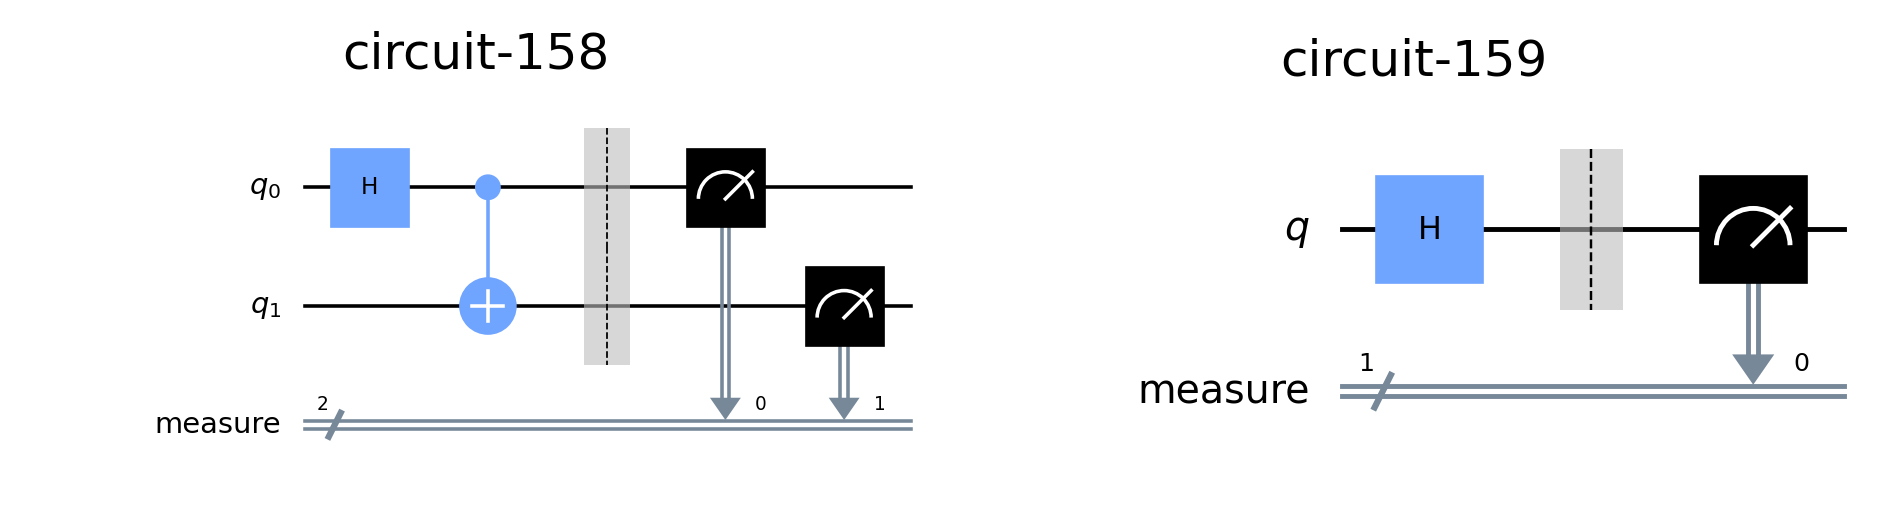

In [3]:
circuits = [qiskit.QuantumCircuit(2)] + [qiskit.QuantumCircuit(1)]
for circuit in circuits:
    circuit.h(0)
    if circuit.width() > 1: circuit.cx(0, 1)
    circuit.measure_active()

plot_circuits(circuits)

We'll also need an object that represents the backend.

In [4]:
backend = iqm.IQMFakeAdonis()
print(f"Backend has {backend.num_qubits} qubits.")

Backend has 5 qubits.


### Defining layouts

Now that we have circuits and a backend for them, we can define a layout. In its simplest form, it
is quite easy: you can pass a list of integer indices that define a virtual-physical mapping. Here
we just pass a single index, since our circuit has only one qubit.

In [5]:
circuits_with_layouts = [
    circuits[0],        # The first circuit has no layout, but...
    (circuits[1], [2]), # the second circuit is forced onto QB3.
]

### Applying the layouts

Now, we finally get to the interesting bit. To demonstrate the effect of the layout, we will
explicitly rearrange the circuits with `parallelizer.rearrange()`.

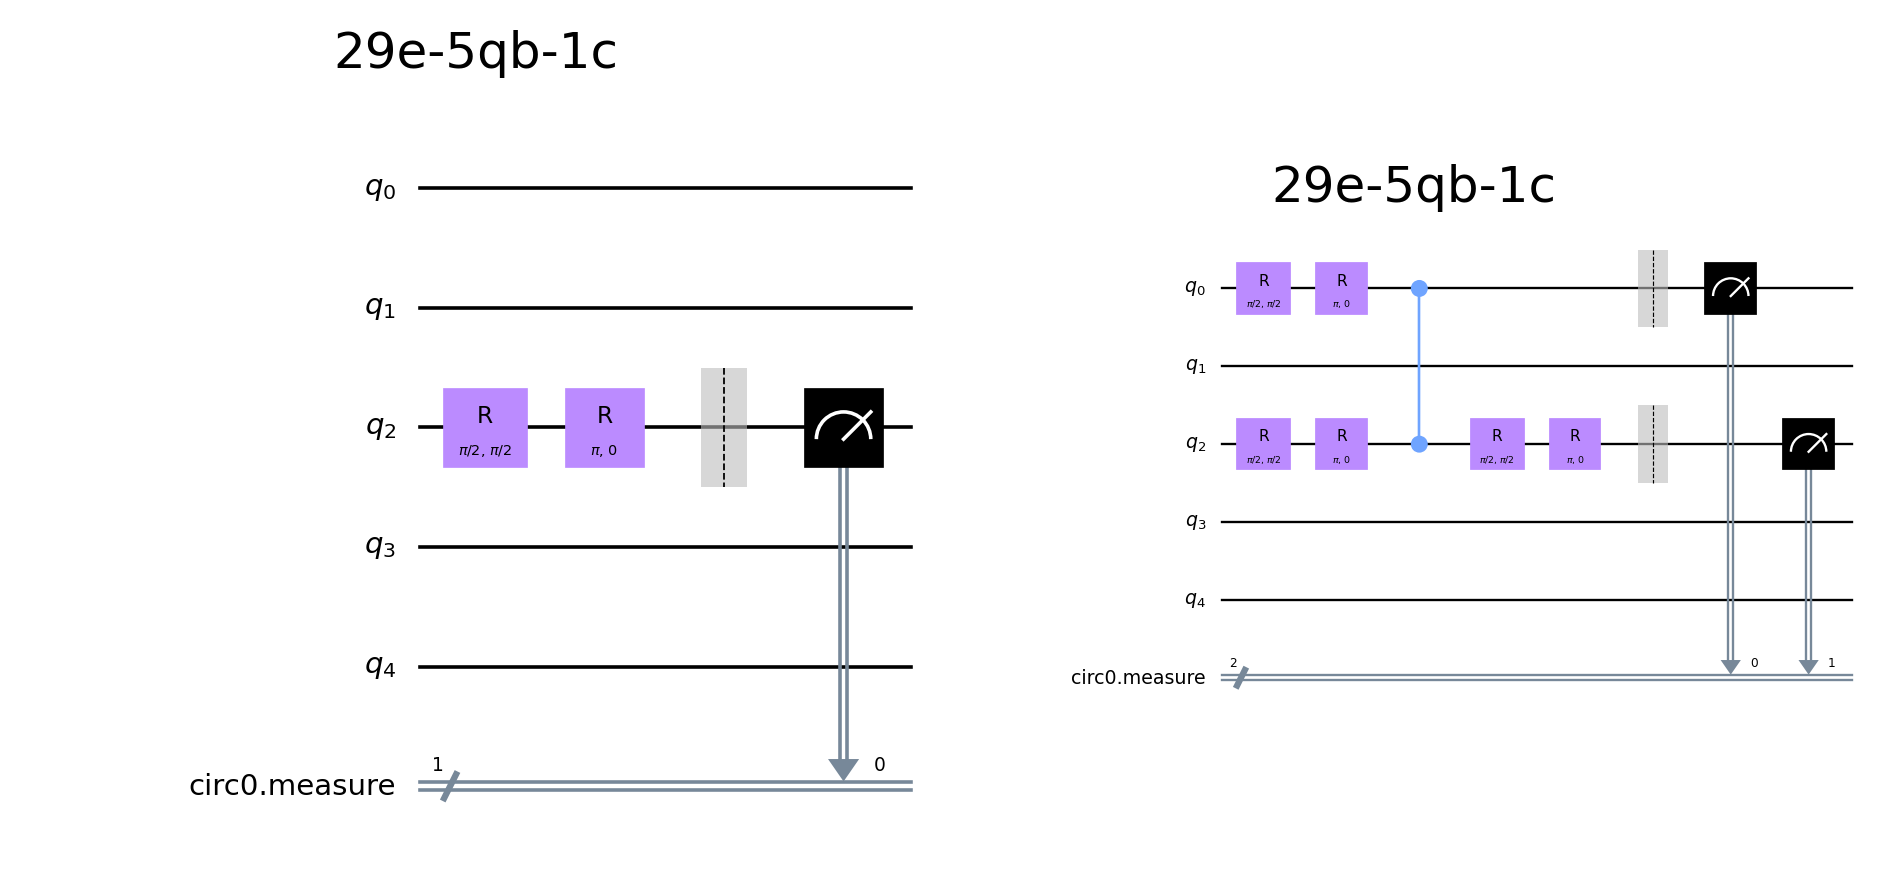

In [6]:
parallel_circuits = parallelizer.rearrange(circuits_with_layouts, backend)
plot_circuits(list(parallel_circuits.values()))

As expected, the circuits were forced onto different host circuits, since one uses QB3 as defined in
its layout and the other requires it due to coupling constraints. They may be in reverse order
compared to what was passed to the parallelizer, but this will be corrected in post-processing.

If we hadn't specified a layout for the smaller circuit, they would have been placed in the same
host.

### Results

Finally, to conclude this demonstration, let us run the circuits and verify that the results are
what we expect.

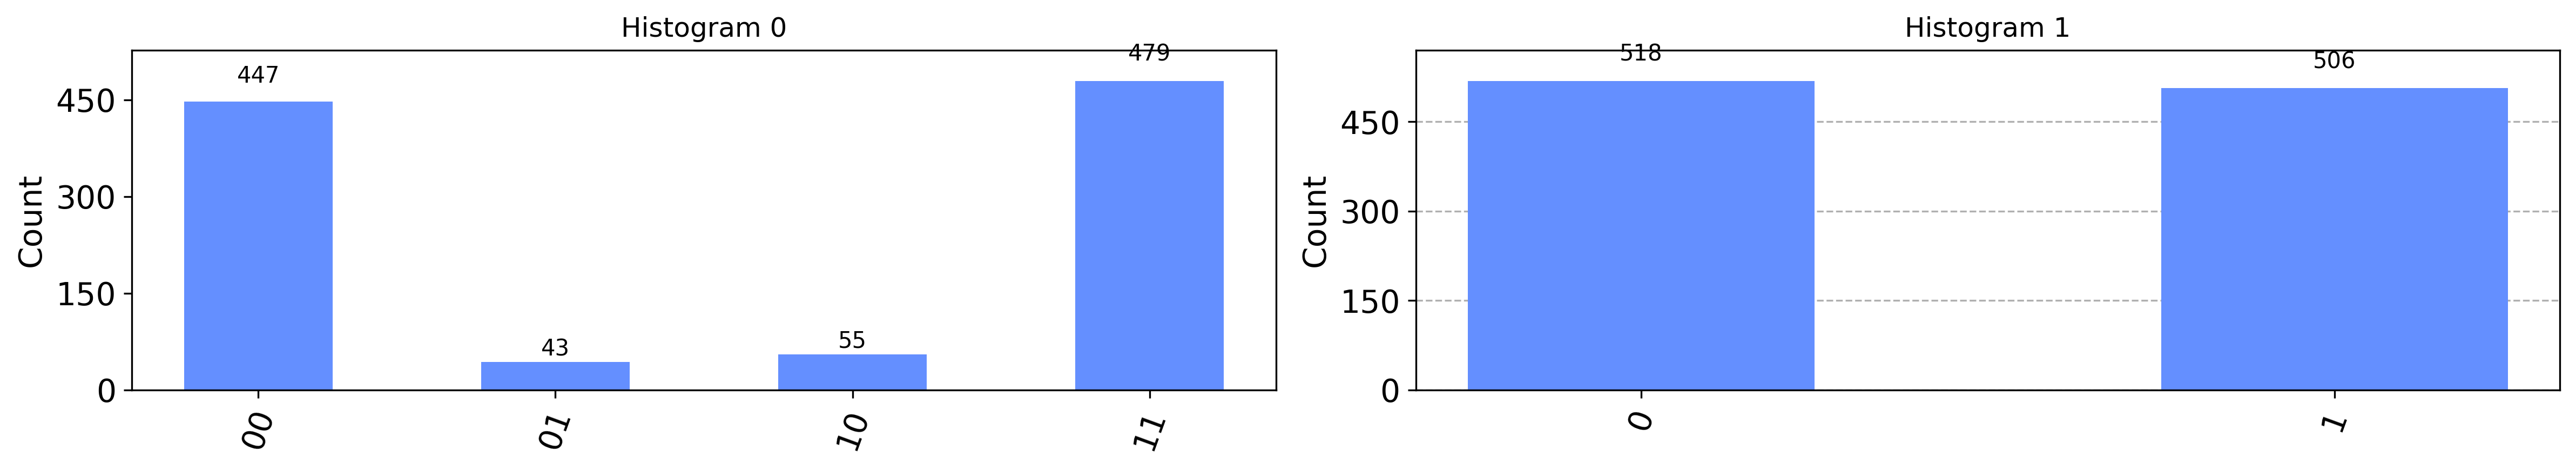

In [7]:
parallel_job = parallelizer.execute(parallel_circuits)
results = parallel_job.results()
plot_histograms([result.get_counts() for result in results], figsize=(16, 3))

Looks good! Also note that the results have been ordered to correspond to the order of the given
circuits.